### Feature engineering
- Missing values of Age replaced with max().
- Cabin: split into multiple columns.
- Add feature "Name does not contain 'Mr.'"
- Add feature "class greater than x"
- LightGBM
##### Changes to previous
- Tuned RandomForest

### Predictions
- One missing value in column "Fare". Replaced with mean. Might be worth doing value imputation.

In [1]:
import os
import re

import numpy as np
import pandas as pd
import pandas_profiling
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_pd = pd.read_csv('Datasets/train.csv').set_index('PassengerId')

In [3]:
pred_pd = pd.read_csv('Datasets/test.csv')

In [4]:
pd.set_option('display.max_rows', None)

## Feature engineering

In [5]:
# On-hot encode Embarked column
enriched_pd = pd.get_dummies(data=data_pd, columns=['Embarked'])

# pred
pred_pd = pd.get_dummies(data=pred_pd, columns=['Embarked'])
enriched_pd.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,0,0


In [6]:
# Transform Sex values
enriched_pd['Female'] = np.where(enriched_pd.Sex == 'female', True, False)

# pred
pred_pd['Female'] = np.where(pred_pd.Sex == 'female', True, False)

In [7]:
enriched_pd.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S,Female
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,False
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,0,0,True


In [8]:
# Age: replace missing values with max
enriched_pd.loc[enriched_pd.Age.isna(), 'Age'] = enriched_pd.Age.max()

# pred
pred_pd.loc[pred_pd.Age.isna(), 'Age'] = enriched_pd.Age.max()

In [9]:
def get_min_cabin_number(row):
    cabins_list = " ".join(re.sub('\D', ' ', row.Cabin).split()).split()
    cabins_list = [int(x) for x in cabins_list]
    if len(cabins_list) > 0:
        return np.min(cabins_list)
    else:
        return 0
    
def get_max_cabin_number(row):
    cabins_list = " ".join(re.sub('\D', ' ', row.Cabin).split()).split()
    cabins_list = [int(x) for x in cabins_list]
    if len(cabins_list) > 0:
        return np.max(cabins_list)
    else:
        return 0
    
def get_cabins_quantity(row):
    if row.Cabin == 'nan':
        return 0
    else:
        return len(row.Cabin.strip().split())

# enriched_pd.Cabins.value_counts()

In [10]:
# Cabin: split into two separate columns
enriched_pd['Cabin'] = enriched_pd['Cabin'].astype('str')
pred_pd['Cabin'] = pred_pd['Cabin'].astype('str')

for letter in ['A', 'B', 'C', 'D', 'E', 'F']:
    enriched_pd[f'Cabin_{letter}'] = enriched_pd['Cabin'].str.contains(letter)
    pred_pd[f'Cabin_{letter}'] = pred_pd['Cabin'].str.contains(letter)
    
enriched_pd['Cabins_quantity'] = enriched_pd.apply(func=get_cabins_quantity, axis=1)
enriched_pd['Cabin_min'] = enriched_pd.apply(func=get_min_cabin_number, axis=1)
enriched_pd['Cabin_max'] = enriched_pd.apply(func=get_max_cabin_number, axis=1)
enriched_pd.drop(columns=['Cabin'], axis=1, inplace=True)

# pred    
pred_pd['Cabins_quantity'] = pred_pd.apply(func=get_cabins_quantity, axis=1)
pred_pd['Cabin_min'] = pred_pd.apply(func=get_min_cabin_number, axis=1)
pred_pd['Cabin_max'] = pred_pd.apply(func=get_max_cabin_number, axis=1)
pred_pd.drop(columns=['Cabin'], axis=1, inplace=True)

In [11]:
# Name
# Add feature "Name does not contain 'Mr.'"
enriched_pd['Not_Mr'] = ~enriched_pd['Name'].str.contains('Mr[.]')
pred_pd['Not_Mr'] = ~pred_pd['Name'].str.contains('Mr[.]')

enriched_pd[['Name', 'Not_Mr']].head()

,Name,Not_Mr
PassengerId,,
1,"Braund, Mr. Owen Harris",False
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",True
3,"Heikkinen, Miss. Laina",True
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",True
5,"Allen, Mr. William Henry",False


In [12]:
# Class
# Add feature "Class greater than x"
enriched_pd['Pclass_gr_1'] = enriched_pd['Pclass'] > 1
enriched_pd['Pclass_gr_2'] = enriched_pd['Pclass'] > 2

pred_pd['Pclass_gr_1'] = pred_pd['Pclass'] > 1
pred_pd['Pclass_gr_2'] = pred_pd['Pclass'] > 2

In [13]:
# Fare: replace missing values with average
pred_pd.loc[pred_pd.Fare.isna(), 'Fare'] = pred_pd.Fare.mean()

In [14]:
# Drop unused columns
enriched_pd = enriched_pd.drop(columns=['Name', 'Sex', 'Ticket'])

pred_pd = pred_pd.drop(columns=['Name', 'Sex', 'Ticket'])

In [15]:
enriched_pd.tail()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Female,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabins_quantity,Cabin_min,Cabin_max,Not_Mr,Pclass_gr_1,Pclass_gr_2
PassengerId,,,,,,,,,,,,,,,,,,,,,
887,0,2,27.0,0,0,13.00,0,0,1,False,...,False,False,False,False,0,0,0,True,True,False
888,1,1,19.0,0,0,30.00,0,0,1,True,...,False,False,False,False,1,42,42,True,False,False
889,0,3,80.0,1,2,23.45,0,0,1,True,...,False,False,False,False,0,0,0,True,True,True
890,1,1,26.0,0,0,30.00,1,0,0,False,...,True,False,False,False,1,148,148,False,False,False
891,0,3,32.0,0,0,7.75,0,1,0,False,...,False,False,False,False,0,0,0,False,True,True


## Split

In [16]:
X = enriched_pd.drop(columns='Survived')
y = enriched_pd.Survived

np.random.seed(16)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.tail(2)

,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Female,Cabin_A,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabins_quantity,Cabin_min,Cabin_max,Not_Mr,Pclass_gr_1,Pclass_gr_2
PassengerId,,,,,,,,,,,,,,,,,,,,,
239,2,19.0,0,0,10.5000,0,0,1,False,False,...,False,False,False,False,0,0,0,False,True,False
682,1,27.0,0,0,76.7292,1,0,0,False,False,...,False,True,False,False,1,49,49,False,False,False


In [17]:
X_train.count()

Pclass             668
Age                668
SibSp              668
Parch              668
Fare               668
Embarked_C         668
Embarked_Q         668
Embarked_S         668
Female             668
Cabin_A            668
Cabin_B            668
Cabin_C            668
Cabin_D            668
Cabin_E            668
Cabin_F            668
Cabins_quantity    668
Cabin_min          668
Cabin_max          668
Not_Mr             668
Pclass_gr_1        668
Pclass_gr_2        668
dtype: int64

## Model building and training

In [18]:
scaler = StandardScaler()
rf = RandomForestClassifier(max_depth=4,
                            min_samples_leaf=10,
                            random_state=16)
model1 = Pipeline([('standardize', scaler),
                   ('rf', rf)])

In [19]:
model1.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=4, min_samples_leaf=10,
                                        random_state=16))])

## Train Score

In [20]:
y_train_hat = model1.predict(X_train)
y_train_hat_probs = model1.predict_proba(X_train)[:,1]

train_accuracy = accuracy_score(y_train, y_train_hat)*100

print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat))
print('Training accuracy: %.4f %%' % train_accuracy)

Confusion matrix:
 [[386  26]
 [ 72 184]]
Training accuracy: 85.3293 %


## Test Score

In [21]:
y_test_hat = model1.predict(X_test)
y_test_hat_probs = model1.predict_proba(X_test)[:,1]

test_accuracy = accuracy_score(y_test, y_test_hat)*100

print('Confusion matrix:\n', confusion_matrix(y_test, y_test_hat))
print('Testing accuracy: %.4f %%' % test_accuracy) 

Confusion matrix:
 [[129   8]
 [ 34  52]]
Testing accuracy: 81.1659 %


## Cross-Validation

In [22]:
scores = cross_validate(model1, X, y, cv=5, scoring=['accuracy'],
                        return_train_score=True)

train_accuracy = scores['train_accuracy']
print(f'Avg train accuracy: {np.mean(train_accuracy)}')
print(f'Train accuracy: {train_accuracy}')

test_accuracy = scores['test_accuracy']
print(f'Avg test accuracy: {np.mean(test_accuracy)}')
print(f'Test accuracy: {test_accuracy}')

Avg train accuracy: 0.8465204784342154
Train accuracy: [0.84550562 0.8569425  0.8401122  0.84852735 0.84151473]
Avg test accuracy: 0.8226916075575922
Test accuracy: [0.80446927 0.80337079 0.86516854 0.81460674 0.8258427 ]


## Submission file

In [23]:
X_train.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Female', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabins_quantity', 'Cabin_min', 'Cabin_max',
       'Not_Mr', 'Pclass_gr_1', 'Pclass_gr_2'],
      dtype='object')

In [24]:
pred_pd.columns

Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Female', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabins_quantity', 'Cabin_min',
       'Cabin_max', 'Not_Mr', 'Pclass_gr_1', 'Pclass_gr_2'],
      dtype='object')

In [25]:
pred_pd.isna().sum() / pred_pd.shape[0]

PassengerId        0.0
Pclass             0.0
Age                0.0
SibSp              0.0
Parch              0.0
Fare               0.0
Embarked_C         0.0
Embarked_Q         0.0
Embarked_S         0.0
Female             0.0
Cabin_A            0.0
Cabin_B            0.0
Cabin_C            0.0
Cabin_D            0.0
Cabin_E            0.0
Cabin_F            0.0
Cabins_quantity    0.0
Cabin_min          0.0
Cabin_max          0.0
Not_Mr             0.0
Pclass_gr_1        0.0
Pclass_gr_2        0.0
dtype: float64

In [26]:
# predict
prediction = model1.predict(X=pred_pd.set_index('PassengerId'))
pred_pd['Survived'] = prediction
pred_pd.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Female,...,Cabin_D,Cabin_E,Cabin_F,Cabins_quantity,Cabin_min,Cabin_max,Not_Mr,Pclass_gr_1,Pclass_gr_2,Survived
0,892,3,34.5,0,0,7.8292,0,1,0,False,...,False,False,False,0,0,0,False,True,True,0
1,893,3,47.0,1,0,7.0000,0,0,1,True,...,False,False,False,0,0,0,True,True,True,0
2,894,2,62.0,0,0,9.6875,0,1,0,False,...,False,False,False,0,0,0,False,True,False,0
3,895,3,27.0,0,0,8.6625,0,0,1,False,...,False,False,False,0,0,0,False,True,True,0
4,896,3,22.0,1,1,12.2875,0,0,1,True,...,False,False,False,0,0,0,True,True,True,0


In [27]:
pred_pd.shape

(418, 23)

In [28]:
# save to csv
pred_pd[['PassengerId', 'Survived']].to_csv('Datasets/Output/submission_06.csv.gz',
                                            index=False, compression='gzip')

## Print tree

#### Feature importance based on mean decrease in impurity

In [29]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

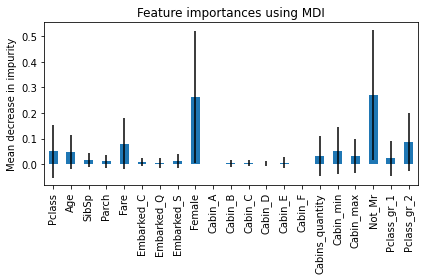

In [30]:
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Most important features:
- Not_Mr
- Female
- Pclass_gr_2
- Fare
- Pclass
- Cabin_min
- Age

#### Feature importance based on feature permutation

In [31]:
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs

/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs

/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs

/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs/titanic/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/oem/miniconda3/envs

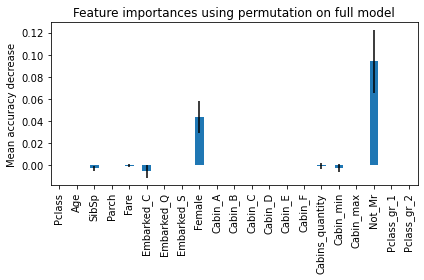

In [32]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()